# This notebook will construct the nodes and edges that we will build our graph with

In this graph, we have two types of nodes, Spectra nodes and PeakRange nodes. A spectra node represents a spectra sample and a PeakRange represents a range of WaveNumber values, where a peak in this range has some presumed chemical or biological meaning based on(Masters Thesis). If a Spectra has a peak in a defined peak range, a relationship will exsist between those two nodes. The weight of the relationship will be the absorbance value of that peak.

Note that the Spectra used here is baseline corrected, smoothed and only uses WaveNumbers between 400 and 1800.

## Importing and Preprocessig Data for Neo4j

Import relevant libraries and import raw data

In [1]:
import sys
sys.path.append('..')  # Adds the parent directory to the path so Python can find the `Cleaning_and_Evaluation` package
from Cleaning_and_Evaluation import *
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

Here we import the neo4j directory and password variables that have been set in our environment

In [2]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

Alternatively you can manually input the neo4j directory and password here

In [3]:
# password = "your_neo4j_password"
# neo4j_directory = "your_neo4j_dbms_directory"

In [4]:
df = pd.read_csv("../data/exosomes.raw_spectrum_400-1800.csv")

Optimal cleaning parameters for kfold cross-validation

In [5]:
cleaning_params = {
    'despike': False,
    'baseline_correct': True,
    'smoothing': True,
    'scaling': False,
    'despike_ma': 10,
    'despike_threshold': 7,
    'lam': 10**9,
    'p': 0.05,
    'window_size': 35,
    'poly_order': 3
}
spectra_cleaning(df, **cleaning_params)

df

,Unnamed: 0,index,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,0,293,201210-1-00,293,400.22778,31.645788,201210-1,Normal
1,1,294,201210-1-00,294,400.91116,31.890799,201210-1,Normal
2,2,295,201210-1-00,295,401.59454,32.060592,201210-1,Normal
3,3,296,201210-1-00,296,402.27789,32.161890,201210-1,Normal
4,4,297,201210-1-00,297,402.96127,32.201418,201210-1,Normal
...,...,...,...,...,...,...,...,...
6239200,6239200,8023277,210526-3-09,2337,1797.03870,-17.773341,210526-3,Hyperglycemia
6239201,6239201,8023278,210526-3-09,2338,1797.72200,-16.954783,210526-3,Hyperglycemia
6239202,6239202,8023279,210526-3-09,2339,1798.40550,-16.058237,210526-3,Hyperglycemia
6239203,6239203,8023280,210526-3-09,2340,1799.08890,-15.079158,210526-3,Hyperglycemia


Here we use scipy's function "find_peaks" to find all peaks in each individual spectra sample as well as pulling featurse such as prominence and width of peaks

In [6]:
peaks = []
widths = []
prom = []

# Here we have the find_peaks function
# Variables such as prominence and width have to be tuned
# This tuning is dependent on the cleaning process done berforehand
for _, group in df.groupby('SpecID'):
    peak_index, weights = find_peaks(x=group['Absorbance'], prominence=72, width=6)
    peaks += list(group.iloc[peak_index].index.values)
    widths += list(weights['widths'])
    prom += list(weights['prominences'])

In [7]:
# Verifying the number of peaks found
print(f"Number of peaks found: {len(peaks)}")

32500


Below shows a scatterplot of the coordinates of all the peaks we have found

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

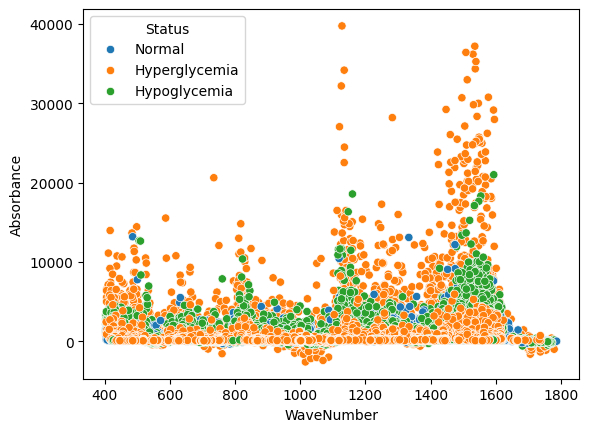

In [8]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", hue="Status")

We then add the peak information to our main dataframe

In [9]:
peak_df = df.iloc[peaks]
peak_df['Widths'] = widths
peak_df['Prominences'] = prom

/tmp/ipykernel_557981/2901317241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Widths'] = widths
/tmp/ipykernel_557981/2901317241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Prominences'] = prom


In [10]:
peak_df.head()

,Unnamed: 0,index,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Widths,Prominences
314,314,607,201210-1-00,607,614.80640,133.732946,201210-1,Normal,57.583810,135.612316
431,431,724,201210-1-00,724,694.76080,159.095461,201210-1,Normal,44.890206,169.775455
732,732,1025,201210-1-00,1025,900.45557,102.112692,201210-1,Normal,115.604479,123.271653
881,881,1174,201210-1-00,1174,1002.27790,95.536068,201210-1,Normal,76.126851,89.799410
1520,1520,1813,201210-1-00,1813,1438.95210,86.415220,201210-1,Normal,59.709555,73.210276


In [11]:
# Peaks ranges with presumed origins
peaks_ranges = [[407, 495], [453, 454], [516, 537], [519, 520], [603, 738],
[620, 624], [821, 839], [886, 887], [972, 973], [1000, 1003],
[1030, 1036], [1060, 1078], [1132, 1152], [1170, 1171],
[1188, 1196], [1212, 1294], [1427, 1446], [1448, 1450],
[1520, 1533], [1542, 1594], [1611, 1653], [1668, 1669],
[402, 562], [510, 550], [618, 624], [634, 795], [808, 812], 
[844, 861], [1001, 1006], [1067, 1068],[1062, 1077], [1129, 1132], 
[1110, 1159], [1150, 1157], [1163, 1172], [1231, 1282], [1250, 1259], 
[1357, 1364], [1429, 1480], [1484, 1492], [1528, 1533], [1544, 1594],
[1582, 1602],[1625, 1643],
[406, 599],[447, 453],[508, 546],[604, 777],[803, 808],
[816, 818],[841, 845],[916, 917],[918, 920],[909, 947],
[1001, 1004],[1032, 1034],[1075, 1078],[1114, 1200],[1162, 1166],
[1202, 1338],[1250, 1253],[1287, 1292],[1436, 1442],[1438, 1439],
[1540, 1595],[1623, 1639]
]

# Convert peaks to a more efficient structure for processing
peak_ranges = [(peak[0], peak[1]) for peak in peaks_ranges]

# Create a function to determine the peak range for each WaveNumber
def find_peak_range(wavenumber):
    for start, end in peak_ranges:
        if start <= wavenumber <= end:
            return f"{start}-{end}"
    return None

# Apply the function to create a new column for peak range
peak_df['PeakRange'] = peak_df['WaveNumber'].apply(find_peak_range)

# Now, group by both SpecID and the new PeakRange column, and compute max Absorbance for each group
grouped = peak_df.groupby(['SpecID', 'PeakRange'])['Absorbance'].max().reset_index()

# Pivot the table to have SpecID as rows and PeakRange as columns, filled with max Absorbance values
efficient_pivot_df = grouped.pivot(index='SpecID', columns='PeakRange', values='Absorbance').reset_index()

efficient_pivot_df.head()


/tmp/ipykernel_557981/2778890601.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['PeakRange'] = peak_df['WaveNumber'].apply(find_peak_range)


PeakRange,SpecID,1000-1003,1001-1006,1030-1036,1060-1078,1110-1159,1114-1200,1129-1132,1132-1152,1163-1172,...,808-812,816-818,821-839,841-845,844-861,886-887,909-947,916-917,918-920,972-973
0,201210-1-00,95.536068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201210-1-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201210-1-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1464.499730,NaN,NaN
3,201210-1-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,625.666908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,990.346692,NaN,NaN
4,201210-1-04,NaN,82.989091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Melt the DataFrame to transform it into a long format
long_format_df = efficient_pivot_df.melt(id_vars='SpecID', var_name='PeakRange', value_name='Weight')

# Drop NaN values
long_format_df.dropna(inplace=True)

long_format_df.reset_index(drop=True, inplace=True)
long_format_df.head()

,SpecID,PeakRange,Weight
0,201210-1-00,1000-1003,95.536068
1,201210-1-05,1000-1003,76.793381
2,201210-1-18,1000-1003,81.130926
3,201210-1-23,1000-1003,96.093581
4,201210-1-24,1000-1003,84.205310


In [13]:
# Renaming and preprocessing for Neo4j
long_format_df.rename(columns={'SpecID':'SpecID:START_ID', 'PeakRange':'PeakRange:END_ID', 'Weight':'Weight:float'}, inplace=True)
long_format_df[':TYPE'] = 'Has_Peak'

In [14]:
# Saving relationships into Neo4j import folder
long_format_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

In [15]:
# Renaming and preprocessing for Neo4j
spectra_df = long_format_df.groupby(['SpecID:START_ID']).first().reset_index()
spectra_df.drop(columns=['PeakRange:END_ID', 'Weight:float', ':TYPE'], inplace=True)
spectra_df.rename(columns={'SpecID:START_ID': 'SpecID:ID'}, inplace=True)
spectra_df[':LABEL'] = 'Spectra'

In [16]:
spectra_df.head()

,SpecID:ID,:LABEL
0,201210-1-00,Spectra
1,201210-1-01,Spectra
2,201210-1-02,Spectra
3,201210-1-03,Spectra
4,201210-1-04,Spectra


In [17]:
# Saving into Neo4j import folder
spectra_df.to_csv(f"{neo4j_directory}/import/spectra.csv", index=False)

In [18]:
# Renaming and preprocessing for Neo4j
peak_range_df = long_format_df.groupby(['PeakRange:END_ID']).first().reset_index()
peak_range_df.drop(columns=['SpecID:START_ID', 'Weight:float', ':TYPE'], inplace=True)
peak_range_df.rename(columns={'PeakRange:END_ID':'PeakRange:ID'}, inplace=True)
peak_range_df[':LABEL'] = 'PeakRange'

In [19]:
# Saving into Neo4j import folder
peak_range_df.to_csv(f"{neo4j_directory}/import/peakrange.csv", index=False)

## Building Graph and Running Graph Algorithms

In [20]:
from neo4j import GraphDatabase
import shutil
import subprocess

Then run the admin import command.

In [21]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/spectra.csv --nodes=import/peakrange.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/spectra.csv', '--nodes=import/peakrange.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
b"Neo4j version: 5.12.0\nImporting the contents of these files into /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data/databases/neo4j:\nNodes:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/spectra.csv\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/peakrange.csv\n\nRelationships:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\n\nAvailable resources:\n  Total machine memory: 15.47GiB\n  Free machine memory: 779.4MiB\n  Max heap memory : 910.5MiB\n  Max worker threads: 8\n  Configured max memory: 376.6MiB\n  High parallel IO: true\n\nCypher type normalization is enabled (disable with --normalize-types=false):\n  Property type of 'Weight' normalized from 'float' --> 'double' in /home/stan

In [22]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Restart successful
b'Stopping Neo4j......... stopped.\nConfiguration file validation successful (with warnings).\nDirectories in use:\nhome:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5\nconfig:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/conf\nlogs:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/logs\nplugins:      /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/plugins\nimport:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import\ndata:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data\ncertificates: /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9f

Run and connect to the Neo4j Database

In [23]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [24]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['PeakRange', 'Spectra'],
      {
        Has_Peak: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Unable to retrieve routing information
Transaction failed and will be retried in 1.1560897551505995s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 2.3216698786218597s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 4.103319795992889s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 8.957119502752207s (Unable to retrieve routing information)


Define the graph algorithms.

In [25]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [26]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [27]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [28]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [29]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, Community
    ORDER BY Community, PeakRange, SpecID
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["Community"]) for record in results]

In [30]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, Community
    ORDER BY Community, PeakRange, SpecID
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["Community"]) for record in results]

In [31]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, Community
    ORDER BY Community, PeakRange, SpecID
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["Community"]) for record in results]

In [32]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [33]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'Weight',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, embedding
    ORDER BY SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [34]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [35]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['SpecID', 'PeakRange', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['SpecID', 'PeakRange', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['SpecID', 'PeakRange', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['SpecID', 'PeakRange', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['SpecID', 'PeakRange', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['SpecID', 'PeakRange', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['SpecID', 'PeakRange', 'Louvain'])

In [36]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['SpecID', 'PeakRange'], how='left')

In [37]:
df = merged_df
df

,SpecID,PeakRange,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,None,1542-1594,211.621124,3.236402e+06,0.634563,204.608201,18,552
1,None,603-738,101.351739,1.168704e+06,0.229096,97.131264,30,567
2,None,1212-1294,99.424238,1.474738e+06,0.288992,94.955032,13,564
3,None,407-495,97.819249,1.615545e+06,0.316629,95.091257,30,560
4,None,1427-1446,81.074021,1.105453e+06,0.216766,78.479796,30,560
...,...,...,...,...,...,...,...,...
2909,210429-1-45,None,0.153346,6.650016e+01,0.000013,0.153249,23,557
2910,210407-1-16,None,0.153109,6.921847e+01,0.000014,0.153017,24,564
2911,210114-2-17,None,0.152996,6.588486e+01,0.000013,0.152909,33,573
2912,210429-1-47,None,0.152989,6.734871e+01,0.000013,0.152903,13,553


In [38]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'PeakRange', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,PeakRange,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,None,0.020722,-0.093693,0.143688,-0.055740,0.204860,-0.040374,0.041415,0.111492,...,0.026494,0.223720,-0.073639,-0.035817,0.249534,-0.066567,0.025876,0.098410,-0.082420,-0.178988
1,201210-1-01,None,0.062242,-0.057492,0.025686,-0.061785,0.170550,0.009453,-0.042163,0.067512,...,0.054148,0.190638,-0.034462,-0.030407,0.286093,-0.066912,-0.070697,0.140389,-0.158930,-0.187492
2,201210-1-02,None,0.116242,-0.094678,0.046021,-0.015687,0.217719,0.110628,0.120933,0.167840,...,0.091813,0.152410,0.010037,0.093067,0.365847,0.023244,-0.049672,0.233583,-0.033692,-0.216609
3,201210-1-03,None,0.080390,-0.134049,0.082387,-0.087424,0.200802,0.045192,0.053052,0.055806,...,0.037699,0.234666,-0.070223,0.109688,0.320055,-0.039167,0.028200,0.099222,-0.005332,-0.127748
4,201210-1-04,None,0.117356,-0.084564,0.044416,-0.045461,0.129697,0.004081,-0.036515,0.039144,...,0.014256,0.158704,-0.041084,-0.042529,0.323991,-0.109115,-0.034678,0.097453,-0.213359,-0.191214


Now that we have all our graph metrics, we need to join back with our nodes dataframe in order to get the status column back and perform some quick cleaning

In [39]:
status_df = peak_df.groupby(['SpecID', 'SurID', 'Status']).first().reset_index()
status_df.drop(columns=['Seq', 'WaveNumber', 'Absorbance', 'Widths', 'Prominences', 'PeakRange'], inplace=True)

graph_df = pd.merge(df, status_df, left_on="SpecID", right_on="SpecID", how="inner")
graph_df.drop(columns=['PeakRange', 'index'], inplace=True)

fast_graph_df = pd.merge(fastRP_df, status_df, left_on="SpecID", right_on="SpecID", how="inner")
fast_graph_df.drop(columns=['PeakRange', 'index'], inplace=True)

graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)
graph_df.set_index("SpecID", inplace=True)

fast_graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)
fast_graph_df.set_index("SpecID", inplace=True)

graph_df.fillna(0, inplace=True)

In [40]:
fast_graph_df.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.020722,-0.093693,0.143688,-0.055740,0.204860,-0.040374,0.041415,0.111492,-0.068079,0.041164,...,-0.073639,-0.035817,0.249534,-0.066567,0.025876,0.098410,-0.082420,-0.178988,201210-1,Normal
201210-1-01,0.062242,-0.057492,0.025686,-0.061785,0.170550,0.009453,-0.042163,0.067512,-0.108127,0.059026,...,-0.034462,-0.030407,0.286093,-0.066912,-0.070697,0.140389,-0.158930,-0.187492,201210-1,Normal
201210-1-02,0.116242,-0.094678,0.046021,-0.015687,0.217719,0.110628,0.120933,0.167840,0.054398,0.126830,...,0.010037,0.093067,0.365847,0.023244,-0.049672,0.233583,-0.033692,-0.216609,201210-1,Normal
201210-1-03,0.080390,-0.134049,0.082387,-0.087424,0.200802,0.045192,0.053052,0.055806,0.004039,-0.011322,...,-0.070223,0.109688,0.320055,-0.039167,0.028200,0.099222,-0.005332,-0.127748,201210-1,Normal
201210-1-04,0.117356,-0.084564,0.044416,-0.045461,0.129697,0.004081,-0.036515,0.039144,-0.116220,0.014668,...,-0.041084,-0.042529,0.323991,-0.109115,-0.034678,0.097453,-0.213359,-0.191214,201210-1,Normal


In [41]:
fast_graph_df.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.020722,-0.093693,0.143688,-0.055740,0.204860,-0.040374,0.041415,0.111492,-0.068079,0.041164,...,-0.073639,-0.035817,0.249534,-0.066567,0.025876,0.098410,-0.082420,-0.178988,201210-1,Normal
201210-1-01,0.062242,-0.057492,0.025686,-0.061785,0.170550,0.009453,-0.042163,0.067512,-0.108127,0.059026,...,-0.034462,-0.030407,0.286093,-0.066912,-0.070697,0.140389,-0.158930,-0.187492,201210-1,Normal
201210-1-02,0.116242,-0.094678,0.046021,-0.015687,0.217719,0.110628,0.120933,0.167840,0.054398,0.126830,...,0.010037,0.093067,0.365847,0.023244,-0.049672,0.233583,-0.033692,-0.216609,201210-1,Normal
201210-1-03,0.080390,-0.134049,0.082387,-0.087424,0.200802,0.045192,0.053052,0.055806,0.004039,-0.011322,...,-0.070223,0.109688,0.320055,-0.039167,0.028200,0.099222,-0.005332,-0.127748,201210-1,Normal
201210-1-04,0.117356,-0.084564,0.044416,-0.045461,0.129697,0.004081,-0.036515,0.039144,-0.116220,0.014668,...,-0.041084,-0.042529,0.323991,-0.109115,-0.034678,0.097453,-0.213359,-0.191214,201210-1,Normal


In [42]:
graph_df.head()

,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,SurID,Status
SpecID,,,,,,,,
210211-2-03,9.092278,177095.671432,0.034642,8.799147,24,564,210211-2,Hyperglycemia
210211-1-01,8.430560,169609.385360,0.033517,8.172894,8,550,210211-1,Hyperglycemia
210211-2-06,7.059544,128887.469438,0.025298,6.835914,4,550,210211-2,Hyperglycemia
210211-1-02,6.762775,134629.995629,0.026602,6.551281,8,550,210211-1,Hyperglycemia
210211-2-09,6.709130,131786.567869,0.025821,6.498269,4,550,210211-2,Hyperglycemia


## Machine Learning Using Graph Metrics

## Centrality Metrics

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=1234)
evaluate_model(graph_df, et, groupkfold=False)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4810 +/- 0.0178
ExtraTreesClassifier Cross-Validation Precision: 0.4801 +/- 0.0187
ExtraTreesClassifier Cross-Validation Recall: 0.4788 +/- 0.0180
ExtraTreesClassifier Cross-Validation F1-Score: 0.4784 +/- 0.0184


## FastRp

In [45]:
evaluate_model(fast_graph_df, et, groupkfold=False)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6126 +/- 0.0157
ExtraTreesClassifier Cross-Validation Precision: 0.6141 +/- 0.0171
ExtraTreesClassifier Cross-Validation Recall: 0.6116 +/- 0.0159
ExtraTreesClassifier Cross-Validation F1-Score: 0.6101 +/- 0.0164


## Fast RP and Centrality

In [46]:
joined_graph = pd.merge(graph_df, fast_graph_df, on=['SpecID', 'Status', 'SurID'], how='inner')

In [47]:
joined_graph.head()

,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,SurID,Status,embedding_0,embedding_1,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
SpecID,,,,,,,,,,,,,,,,,,,,,
210211-2-03,9.092278,177095.671432,0.034642,8.799147,24,564,210211-2,Hyperglycemia,0.127808,-0.150391,...,0.105008,0.145062,-0.148424,-0.043657,0.231692,-0.072577,0.074451,-0.003409,0.038251,-0.116788
210211-1-01,8.430560,169609.385360,0.033517,8.172894,8,550,210211-1,Hyperglycemia,0.087690,-0.169147,...,0.130616,0.067482,-0.041981,-0.026352,0.268854,-0.070418,0.028585,-0.066244,-0.039198,-0.130613
210211-2-06,7.059544,128887.469438,0.025298,6.835914,4,550,210211-2,Hyperglycemia,0.025366,-0.197084,...,0.078366,0.143981,-0.021365,-0.054640,0.330882,-0.129506,0.013227,0.020310,-0.029118,-0.182737
210211-1-02,6.762775,134629.995629,0.026602,6.551281,8,550,210211-1,Hyperglycemia,0.079111,-0.161877,...,0.100823,0.048801,-0.018294,-0.011251,0.267750,-0.066878,-0.007770,-0.027497,-0.056802,-0.144783
210211-2-09,6.709130,131786.567869,0.025821,6.498269,4,550,210211-2,Hyperglycemia,0.088931,-0.176037,...,0.041507,0.181824,0.009603,-0.017627,0.267763,-0.119230,-0.031335,0.009686,-0.066662,-0.088473


In [48]:
evaluate_model(joined_graph, et, groupkfold=False)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6439 +/- 0.0285
ExtraTreesClassifier Cross-Validation Precision: 0.6427 +/- 0.0292
ExtraTreesClassifier Cross-Validation Recall: 0.6421 +/- 0.0291
ExtraTreesClassifier Cross-Validation F1-Score: 0.6417 +/- 0.0293


Delete the projection

In [49]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [50]:
close_driver()